# Marginalization index at h3 resolution 9

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Donwload data

In [2]:
hex_prox = aup.gdf_from_db('volvo_proxanalysis_2024_mza_hex9', 'projects_research')
print(hex_prox.shape)
hex_prox.head(2)

(5639, 49)


,hex_id,res,max_escuelas,min_escuelas,time_guarderías,time_preescolar,time_primaria,time_secundaria,max_salud,min_salud,...,unidad deportiva_15min,cultural_15min,cines_15min,museos_15min,bibliotecas_15min,financiero_15min,bancos_15min,pobtot,dens_pob_ha,geometry
0,8949aa252bbffff,9,65.700136,5.424581,65.700136,18.338011,15.153014,5.424581,65.126155,13.229981,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,895.0,72.377587,"POLYGON ((-103.40480 20.46253, -103.40358 20.4..."
1,8949ab5943bffff,9,38.509210,27.956565,29.104480,28.120892,27.956565,38.509210,18.872854,17.391323,...,0.0,0.0,0.0,0.0,0.0,6.055556,6.055556,19.0,1.536037,"POLYGON ((-103.40982 20.60369, -103.40860 20.6..."


In [3]:
gdf = hex_prox.to_crs("EPSG:6372")
gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
gdf = gdf.set_geometry("geometry")
gdf = gdf.to_crs("EPSG:4326")
poly_wkt = gdf.dissolve().geometry.to_wkt()[0]

In [4]:
schema = 'censo'
folder = 'nodes_marg_2020'
nodes_query = f"SELECT * FROM {schema}.{folder} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
nodes_marg = aup.gdf_from_query(nodes_query, geometry_col="geometry")
print(nodes_marg.shape)
nodes_marg.head(2)

(150432, 31)


,x,y,street_count,geometry,cve_geo_ageb,cve_ent,cve_mun,cve_loc,cve_ageb,CVE_AGEB,...,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,-103.388734,20.420667,0,POINT (-103.38873 20.42067),1409700150227,14,097,0015,0227,1409700150227,...,0.009303,0.0,0.025251,0.035883,0.126256,1.027324,0.102334,0.556855,120.042673,0.937728
1,-103.388584,20.420591,0,POINT (-103.38858 20.42059),1409700150227,14,097,0015,0227,1409700150227,...,0.009303,0.0,0.025251,0.035883,0.126256,1.027324,0.102334,0.556855,120.042673,0.937728


## Spatial union

In [5]:
nodes_marg.columns

Index(['x', 'y', 'street_count', 'geometry', 'cve_geo_ageb', 'cve_ent',
       'cve_mun', 'cve_loc', 'cve_ageb', 'CVE_AGEB', 'entidad', 'nom_ent',
       'mun', 'nom_mun', 'loc', 'nom_loc', 'ageb', 'pobtot', 'p6a14nae',
       'sbasc', 'psdss', 'ovsde', 'ovsee', 'ovsae', 'ovpt', 'ovsref', 'ovsint',
       'ovscel', 'ovhac', 'im_2020', 'imn_2020'],
      dtype='object')

In [6]:
string_cols = ['cve_geo_ageb','cve_ent','cve_mun',
              'cve_loc','cve_ageb','CVE_AGEB','entidad','nom_ent',
              'mun','nom_mun','loc','nom_loc','ageb']
wgt_col = {'imn_2020':'pobtot'}

In [7]:
hex_marg = aup.socio_points_to_polygon(hex_prox[['hex_id','res','geometry']], nodes_marg, 'hex_id',string_cols, wgt_dict=wgt_col, avg_column=['imn_2020'])
print(hex_marg.shape)
hex_marg.head(2)

(5531, 18)


,x,y,street_count,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020,hex_id
0,-1964.380615,387.975189,0.0,719.492554,3.345561,14.151299,8.509437,0.130243,0.0,0.353517,0.733799,2.320189,19.757462,2.509546,11.248577,2277.076904,0.935141,8949aa20b97ffff
1,-1447.392456,285.852966,0.0,435.579285,2.414253,9.705949,5.197040,0.120940,0.0,0.328265,0.512769,1.751848,14.430203,1.545713,7.929638,1679.850830,0.936874,8949aa20b93ffff


In [8]:
hex_prox = hex_prox.merge(hex_marg[['hex_id','imn_2020']], on='hex_id')

<AxesSubplot: >

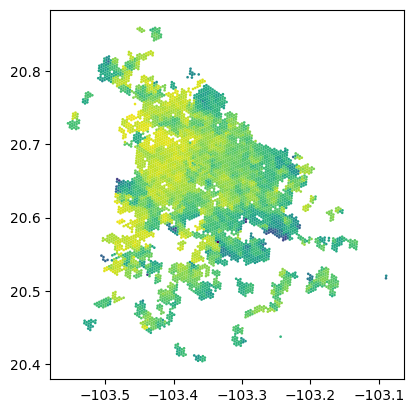

In [9]:
hex_prox.plot('imn_2020')

## Upload to db

In [10]:
hex_prox = hex_prox.set_crs("EPSG:4326")

In [11]:
aup.gdf_to_db_slow(hex_prox, 'volvo_proxanalysis_2024_mza_hex9', 'projects_research', if_exists='replace')